# Main Project Notebook

Model Candidate #1  
$ A * \sin(f_{1}t +b_1)\sin(f_{2}t + b_2)$  

Model Candidate #2 (more likely)  
$ A_1\sin(f_{1}t +b_1) + A_2\sin(f_{2}t + b_2)$

### Cell 1

In this cell we import all of the module/functions we're going to be using. For readability's sake, I suggest we add them in the order that we use them.

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

### Cell 2

This is where we should read in the data. I didn't realize that the `.txt` file was a in FITS format so I wrote a whole script to get the data in the format we wanted. I think we should find a way to use the `astropy` package to open it like the we did in Lecture 15. 

In [103]:
from getdata import get_data

# day, time, and height are all dicts with the label,description, and numpy data
# from the provided file. Need to rewrite to use astropy.
day, time, height = get_data() 
daydata = day['data']
timedata = time['data']
heightdata = height['data']

### Cell 3

Here is where we took our first look at the data.

 - I combined the `daydata` (in days) and `timedata` (in hours and minutes) into a single `timedata` that is only in minutes.
 - Plotting `heightdata` vs time reveals an oscillatory pattern
 - Data has at least two frequencies clearly visible
   - one is approximately daily
   - the other is 

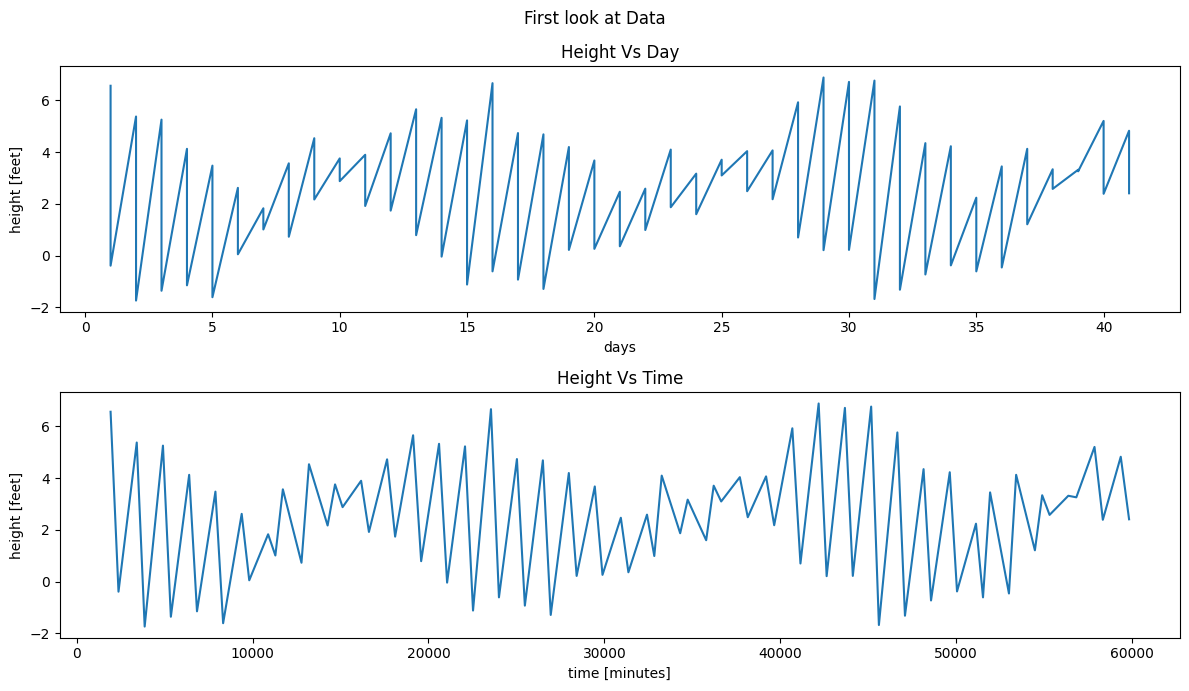

In [ ]:
timedata = daydata*24*60 + timedata
fig,ax = plt.subplots(2,1,figsize=(12,7), )

fig.suptitle('First look at Data')

# plot using just day data has artifact (slanted parts)
ax[0].plot(daydata,heightdata)
ax[0].set_title('Height Vs Day')
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Height [Feet]')


# plot of combined time [minute] data does not have artifacts, but
# we'll still need to keep track of day/hour/minute somehow. 
ax[1].set_title('Height Vs Time')
ax[1].plot(timedata,heightdata)
ax[1].set_xlabel('Time [Minutes]')
ax[1].set_ylabel('Height [Feet]')

plt.tight_layout()
plt.show()
